**Problem**: 

Approximating the non-linear data space that makes up a PyPSA simulation. Specifically, approximating a modified IEEE 13 bus topology with a uniform (grid) input. The approximation is time sensitive.

**Objective**:

This notebook will only look at [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (RF) models. Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will also be calculated for baseline comparison. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, a linear regression model outperformed a non-linear model (artificial neural network) when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Transformer limit not exceeded: Linear regression outperforms RF model
2. Transformer limit exceeded: RF outperforms linear regressor because a RF model can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with SVR K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

* 1e5 samples (mean R2: 0.85, std dev: 0.0005)
* 1e4 samples (mean R2: 0.81, std dev: 0.005)

Running a randomized grid search with 1e5 samples produced the following results:

1. n_estimators: 99, max_depth: 73, mean training time: 226s (mean R2: 0.85 std dev: 0.0006)
2. n_estimators: 89, max_depth: 62, mean training time: 208s (mean R2: 0.85 std dev: 0.0006)
3. .
4. .


18. n_estimators: 24, max_depth: 68, mean training time: 54s (mean R2: 0.84 std dev: 0.001)
19. n_estimators: 3, max_depth: 19, mean training time: 7s (mean R2: 0.77 std dev: 0.001)
20. n_estimators: 36, max_depth: 9, mean training time: 55s (mean R2: 0.74 std dev: 0.002)

**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup models
* Determine number of samples to get reasonable scores
* Search

In [1]:
import pypsa
import time
import logging
import numpy as np
import warnings

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

import copy
import csv
import sys
import time

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import pypsa
from n_dimensional_datasets import *
from plotter import *

from IPython.display import display # for better Pandas printing

In [5]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name +  "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)

def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")
    
import pandas as pd
import numpy as np
    
def set_gaussian_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''

    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    '''
    n_original_samples = 2 # sample_1 from IEEE-13 paper, sample_2=0.9*sample_1

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")
        

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:  
                addon[column] = np.abs(
                    np.random.RandomState(seed=seed).normal(loc=dataframe[column][0:n_original_samples].mean(), 
                                                            scale=dataframe[column][0:n_original_samples].std(), 
                                                            size=n_samples))
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][n_original_samples-1])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(n_original_samples).append(addon_dataframe)            

            
    def cap_data(dataframe, min_value, max_value):
        for column in dataframe:
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                for i, val in enumerate(dataframe[column]):
                    if val > max_value:
                        dataframe[column][i] = max_value
                    elif val < min_value:
                        dataframe[column][i] = min_value
        return dataframe
    

    if n_samples > n_original_samples:
        for datatype in data:
            data[datatype] = increase_data(data[datatype], n_samples-n_original_samples, seed)
            if datatype == "generators-p_max_pu":
                data[datatype] = cap_data(data[datatype], 0, 1)
        
    for datatype in data:
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))

def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    import shutil
    from pathlib import Path
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/" # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_gaussian_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")
    
def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import os
    import errno
    import shutil
    
    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)                          + str(sample_size) +


# Source Data

In [25]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example +
                          "/ieee-13-with-load-gen-gaussian-data-"
                          + str(sample_size) +
                          "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [ ]:
## Uncomment to generate load samples for modified IEEE-13 network
if sample_size > 10000:
    user = input("Are you sure [y/n]? This could erase hours worth of data")
    if user == "y":
        backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
        create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
else:
    create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

Are you sure [y/n]? This could erase hours worth of datay
Directory not copied. Error: [Errno 2] No such file or directory: '../../pypsa/examples/ieee-13//ieee-13-with-load-gen-gaussian-data-100000-samples/results/'
Datatype loads-p_set stored
Datatype snapshots stored
Datatype loads-q_set stored


# Analyse Data

In [21]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1) #loc[:,["vmag-632", "vmag-671", "vmag-675"]]
features_and_labels = features.join(labels)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bc8b0dd90>,
      dtype=object)

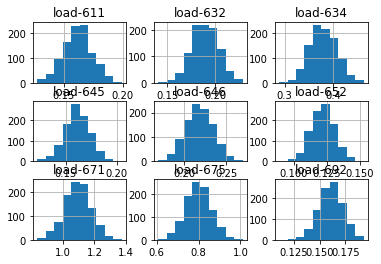

In [22]:
features.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bc7cc3810>,
      dtype=object)

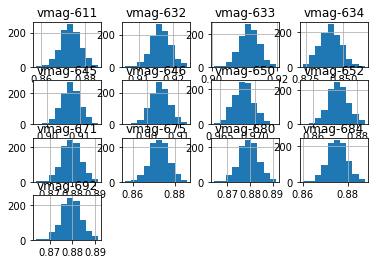

In [23]:
labels.hist()

In [24]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,0.012636,-0.134912,0.009150,0.012292,-0.091244,-0.137399,-0.111013,-0.050161,-0.019930,-0.056731
vmag-646,-0.075102,-0.243435,-0.153393,-0.297267,-0.142804,-0.563048,-0.421137,-0.099218,-0.098410,-0.232646
vmag-645,-0.078678,-0.245490,-0.155140,-0.228137,-0.143392,-0.574592,-0.427127,-0.102543,-0.100118,-0.228357
vmag-632,-0.079974,-0.249377,-0.058542,-0.102455,-0.148531,-0.596171,-0.437501,-0.108841,-0.099245,-0.208960
vmag-633,-0.077283,-0.356019,-0.055181,-0.102521,-0.144726,-0.577364,-0.419764,-0.102999,-0.093009,-0.214319
vmag-634,-0.010840,-0.276802,-0.009663,-0.029756,-0.064641,-0.274859,-0.206299,-0.061779,-0.008524,-0.104796
vmag-611,-0.054882,-0.166390,-0.033259,-0.074525,-0.177280,-0.693963,-0.507999,-0.122130,-0.192113,-0.224727
vmag-684,-0.056175,-0.168136,-0.032136,-0.074845,-0.179226,-0.697899,-0.510811,-0.122561,-0.155550,-0.221927
vmag-671,-0.056743,-0.170133,-0.032302,-0.074533,-0.153910,-0.702383,-0.515142,-0.123008,-0.119938,-0.216455
vmag-692,-0.056730,-0.170106,-0.032296,-0.074529,-0.153892,-0.702288,-0.515314,-0.123044,-0.119927,-0.216459


# Setup Models

In [10]:
import csv
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from scoring import rmse

In [11]:
def set_data_size(n_samples, n_training_samples):
    X_train, X_val, y_train, y_val, test_idx, train_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)
    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val

# Determine number of samples to get reasonable scores

In [12]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
rf = RandomForestRegressor(n_estimators=100, max_depth=None)

linear = LinearRegression()

In [13]:
# cell works, may just be commented out because it is an expensive process and user can just skip to grid search
rf_xval_scores = []
linear_xval_scores = []
for i, n_samples in enumerate([100, 1000, 10000, 100000]):
    current_iteration = i

    n_training_samples = int(n_samples*(80/100))
    X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

    print("\n\nRun: ", current_iteration)
    print("n_training_samples: ", n_training_samples)
    print("n_validation_samples: ", n_samples-n_training_samples)
    print("n_features: ", X_train.shape[1])
    print("n_labels: ", y_train.shape[1])

    ## rf
    print("\n\nRF\n\n")
    time_start = time.time()
    rf_xval_scores.append(cross_validate(rf, 
                                         X_train, 
                                         y_train, 
                                         cv=5, 
                                         n_jobs=-1, 
                                         scoring=make_scorer(r2_score)))
    time_rf = time.time()
    print("cross validation training time {:.5}".format(time_rf-time_start))
    print("cross validation training scores: ")
    rf_results = pd.DataFrame(rf_xval_scores[current_iteration])
    rf_results.columns = ["rf_"+col for col in rf_results.columns]   
    display(rf_results)

    rf.fit(X_train, y_train)
    print("non-cross validation model scores for reference:")
    print("training score: ", r2_score(y_train, rf.predict(X_train)))
    print("validation score: ", r2_score(y_val, rf.predict(X_val)))
    print("rmse: ", rmse(rf.predict(X_val), y_val))



    ## linear regression
    print("\n\nLINEAR REGRESSION\n\n")
    time_start = time.time()
    linear_xval_scores.append(cross_validate(linear,
                                             X_train,
                                             y_train,
                                             cv=5,
                                             n_jobs=-1,
                                             scoring=make_scorer(r2_score)))

    time_linear = time.time()
    print("cross validation training time {:.5}".format(time_linear-time_start))
    print("cross validation training scores: ")
    linear_results = pd.DataFrame(linear_xval_scores[current_iteration])
    linear_results.columns = ["linear_"+col for col in linear_results.columns]
    display(linear_results)

    linear.fit(X_train, y_train)
    print("non-cross validation model scores for reference:")
    print("training score: ", r2_score(y_train, linear.predict(X_train)))
    print("validation score: ", r2_score(y_val, linear.predict(X_val)))
    print("rmse: ", rmse(linear.predict(X_val), y_val))

    ## model statistics
    datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    results_to_save = rf_results.join(linear_results).round(3)
    results_to_save.to_csv(path_to_powerflow_data + 
                           "/results/approximating_with_rf_results-{}_samples-{}.csv".format(n_samples, 
                                                                                             datetimestamp))



Run:  0
n_training_samples:  80
n_validation_samples:  20
n_features:  9
n_labels:  13


RF


cross validation training time 1.3524
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_score
0,0.110896,0.006425,0.495420
1,0.109646,0.007320,0.444909
2,0.105972,0.006288,0.554424
3,0.115606,0.007122,0.485012
4,0.130301,0.008294,0.659086


non-cross validation model scores for reference:
training score:  0.9339916186598655
validation score:  0.344923767761198
rmse:  0.0071490201286817925


LINEAR REGRESSION


cross validation training time 0.049087
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_score
0,0.036883,0.000584,0.867815
1,0.035001,0.000624,0.877943
2,0.001012,0.000586,0.874488
3,0.000860,0.000523,0.818003
4,0.000769,0.000701,0.909008


non-cross validation model scores for reference:
training score:  0.9163827658436261
validation score:  0.8995918741505837
rmse:  0.0014528532309112843


Run:  1
n_training_samples:  800
n_validation_samples:  200
n_features:  9
n_labels:  13


RF


cross validation training time 1.8951
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_score
0,0.720907,0.010676,0.727136
1,0.610899,0.010670,0.702023
2,0.628827,0.011750,0.741247
3,0.602864,0.012140,0.670512
4,0.596581,0.009748,0.717082


non-cross validation model scores for reference:
training score:  0.9609072831786946
validation score:  0.7323838860566172
rmse:  0.0043356551744515425


LINEAR REGRESSION


cross validation training time 0.017804
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_score
0,0.003929,0.000908,0.905695
1,0.001454,0.000454,0.901053
2,0.001023,0.000425,0.902635
3,0.001023,0.000426,0.906900
4,0.000993,0.000448,0.905400


non-cross validation model scores for reference:
training score:  0.907537607780207
validation score:  0.8989295617735344
rmse:  0.0015184944621667296


Run:  2
n_training_samples:  8000
n_validation_samples:  2000
n_features:  9
n_labels:  13


RF


cross validation training time 22.981
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_score
0,7.588874,0.066067,0.799829
1,7.597608,0.093956,0.804329
2,7.594231,0.067965,0.804885
3,7.420056,0.078523,0.811381
4,7.639505,0.066204,0.807828


non-cross validation model scores for reference:
training score:  0.9731189517099799
validation score:  0.8098179673664383
rmse:  0.0034043066464187256


LINEAR REGRESSION


cross validation training time 0.051679
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_score
0,0.006047,0.001056,0.905314
1,0.006931,0.001021,0.906182
2,0.004909,0.000984,0.903689
3,0.004776,0.000963,0.905873
4,0.004795,0.000962,0.905444


non-cross validation model scores for reference:
training score:  0.9056681800512134
validation score:  0.9057412338069443
rmse:  0.0013931534879083958


Run:  3
n_training_samples:  80000
n_validation_samples:  20000
n_features:  9
n_labels:  13


RF




KeyboardInterrupt: 

# Search

In [16]:
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

In [ ]:
n_samples = 100000
if n_samples < 100000:
    raise ValueError("So you don't accidentally run this on 100 samples again")
n_training_samples = int(n_samples*(80/100))
X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

In [ ]:
rf = RandomForestRegressor()
params = {"n_estimators": range(100), 
          "max_depth": [None]+[i for i in range(1, 100)]}
grid = RandomizedSearchCV(rf, params, cv=5, n_iter=20, n_jobs=-1, refit=False,
                          scoring={"r2": make_scorer(r2_score), "rmse": make_scorer(rmse)}, iid=False, verbose=10)

grid.fit(X_train, y_train)

print("\n\nRF\n\n")
grid_results = pd.DataFrame(grid.cv_results_)
display(grid_results.sort_values(by=["rank_test_r2"]))
datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
filepath = (path_to_powerflow_data + 
            "/results/approximating_with_rf_grid_results-{}_samples-{}.csv".format(n_samples, datetimestamp))
print("Saving to ", filepath)
grid_results.to_csv(filepath)

In [ ]:
# for reading values if you closed the notebook
imported_results = pd.read_csv(filepath)
display(imported_results.sort_values(by=["rank_test_r2"]))

# Search after removing bad label

In [17]:
n_samples = 100000
if n_samples < 100000:
    raise ValueError("So you don't accidentally run this on 100 samples again")
n_training_samples = int(n_samples*(80/100))
X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)
# remove bad label
y_train = y_train.T[1:].T
y_val = y_val.T[1:].T

In [18]:
rf = RandomForestRegressor()
params = {"n_estimators": range(100), 
          "max_depth": [None]+[i for i in range(1, 100)]}
grid = RandomizedSearchCV(rf, params, cv=3, n_iter=10, n_jobs=-1, refit=False,
                          scoring={"r2": make_scorer(r2_score), "rmse": make_scorer(rmse)}, iid=False, verbose=10)

grid.fit(X_train, y_train)

print("\n\nRF\n\n")
grid_results = pd.DataFrame(grid.cv_results_)
display(grid_results.sort_values(by=["rank_test_r2"]))
datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
filepath = (path_to_powerflow_data + 
            "/results/approximating_with_rf_grid_results-{}_samples-{}.csv".format(n_samples, datetimestamp))
print("Saving to ", filepath)
grid_results.to_csv(filepath)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.8min




RF




[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,66.531391,0.622077,2.545954,0.086762,80,29,"{'n_estimators': 80, 'max_depth': 29}",0.921858,0.922751,0.922099,0.922236,0.000377,1,0.002894,0.002883,0.002889,0.002889,0.000004,10
5,59.921115,0.734938,2.203448,0.029155,72,98,"{'n_estimators': 72, 'max_depth': 98}",0.921811,0.921741,0.921164,0.921572,0.000290,2,0.002894,0.002901,0.002907,0.002901,0.000005,9
7,52.694661,0.098162,2.040517,0.075283,64,33,"{'n_estimators': 64, 'max_depth': 33}",0.921495,0.921932,0.921088,0.921505,0.000345,3,0.002899,0.002897,0.002909,0.002902,0.000005,8
9,42.708556,0.272464,1.667782,0.055191,52,71,"{'n_estimators': 52, 'max_depth': 71}",0.920678,0.921160,0.921027,0.920955,0.000203,4,0.002914,0.002911,0.002911,0.002912,0.000001,7
6,49.611883,0.197651,1.920520,0.055440,60,93,"{'n_estimators': 60, 'max_depth': 93}",0.920492,0.921506,0.920086,0.920695,0.000597,5,0.002919,0.002905,0.002928,0.002917,0.000009,6
4,32.702112,0.183965,1.336063,0.059603,40,74,"{'n_estimators': 40, 'max_depth': 74}",0.918704,0.919897,0.919109,0.919237,0.000495,6,0.002951,0.002934,0.002942,0.002942,0.000007,5
1,20.698034,0.078871,0.903889,0.030214,25,73,"{'n_estimators': 25, 'max_depth': 73}",0.915674,0.917252,0.916619,0.916515,0.000648,7,0.003008,0.002984,0.002990,0.002994,0.000010,4
2,19.139486,0.097723,0.843532,0.018133,23,66,"{'n_estimators': 23, 'max_depth': 66}",0.915774,0.915434,0.915281,0.915496,0.000206,8,0.003007,0.003020,0.003011,0.003013,0.000005,3
3,8.422979,0.240346,0.468810,0.022842,10,48,"{'n_estimators': 10, 'max_depth': 48}",0.903202,0.904700,0.903273,0.903725,0.000690,9,0.003218,0.003203,0.003221,0.003214,0.000008,2
8,6.304425,0.014633,0.322273,0.010596,23,4,"{'n_estimators': 23, 'max_depth': 4}",0.475762,0.463664,0.459374,0.466267,0.006939,10,0.007396,0.007507,0.007516,0.007473,0.000054,1


Saving to  ../../pypsa/examples/ieee-13//ieee-13-with-load-gen-uniform-data-100000-samples//results/approximating_with_rf_grid_results-100000_samples-2019-09-13-07-25.csv


In [19]:
# for reading values if you closed the notebook
imported_results = pd.read_csv(filepath)
display(imported_results.sort_values(by=["rank_test_r2"]))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,0,66.531391,0.622077,2.545954,0.086762,80,29,"{'n_estimators': 80, 'max_depth': 29}",0.921858,0.922751,0.922099,0.922236,0.000377,1,0.002894,0.002883,0.002889,0.002889,0.000004,10
5,5,59.921115,0.734938,2.203448,0.029155,72,98,"{'n_estimators': 72, 'max_depth': 98}",0.921811,0.921741,0.921164,0.921572,0.000290,2,0.002894,0.002901,0.002907,0.002901,0.000005,9
7,7,52.694661,0.098162,2.040517,0.075283,64,33,"{'n_estimators': 64, 'max_depth': 33}",0.921495,0.921932,0.921088,0.921505,0.000345,3,0.002899,0.002897,0.002909,0.002902,0.000005,8
9,9,42.708556,0.272464,1.667782,0.055191,52,71,"{'n_estimators': 52, 'max_depth': 71}",0.920678,0.921160,0.921027,0.920955,0.000203,4,0.002914,0.002911,0.002911,0.002912,0.000001,7
6,6,49.611883,0.197651,1.920520,0.055440,60,93,"{'n_estimators': 60, 'max_depth': 93}",0.920492,0.921506,0.920086,0.920695,0.000597,5,0.002919,0.002905,0.002928,0.002917,0.000009,6
4,4,32.702112,0.183965,1.336063,0.059603,40,74,"{'n_estimators': 40, 'max_depth': 74}",0.918704,0.919897,0.919109,0.919237,0.000495,6,0.002951,0.002934,0.002942,0.002942,0.000007,5
1,1,20.698034,0.078871,0.903889,0.030214,25,73,"{'n_estimators': 25, 'max_depth': 73}",0.915674,0.917252,0.916619,0.916515,0.000648,7,0.003008,0.002984,0.002990,0.002994,0.000010,4
2,2,19.139486,0.097723,0.843532,0.018133,23,66,"{'n_estimators': 23, 'max_depth': 66}",0.915774,0.915434,0.915281,0.915496,0.000206,8,0.003007,0.003020,0.003011,0.003013,0.000005,3
3,3,8.422979,0.240346,0.468810,0.022842,10,48,"{'n_estimators': 10, 'max_depth': 48}",0.903202,0.904700,0.903273,0.903725,0.000690,9,0.003218,0.003203,0.003221,0.003214,0.000008,2
8,8,6.304425,0.014633,0.322273,0.010596,23,4,"{'n_estimators': 23, 'max_depth': 4}",0.475762,0.463664,0.459374,0.466267,0.006939,10,0.007396,0.007507,0.007516,0.007473,0.000054,1
